# Get cluster scatter

In [1]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import astropy.stats as aps
from tqdm.notebook import tqdm
from tqdm import trange

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load cluster data and apply cuts

In [3]:
clusters = pd.read_csv("../data/dbf12.csv")

# Do all sorts of cuts on the clusters to remove scatter.
# Remove points that are redder than 1.5 AND have periods shorter than 11 days to get rid of scatter.
ms = (clusters["(BP-RP)0"].values > 1.5) & (clusters.prot.values < 11)

# Remove any rotation periods shorter than 1 day, stars redder than 2.2.
not_fast = (clusters.prot.values[~ms] > 1) & (clusters["(BP-RP)0"].values[~ms] < 2.7) & (clusters["(BP-RP)0"].values[~ms] < 2.2)

# Remove the Pleiades non-converged stars and three outliers.
# no_pleiades = clusters.age_gyr.values[~ms][not_fast] < 0.2
no_pleiades = (clusters.age_gyr.values[~ms][not_fast] <= 0.2) & (clusters["(BP-RP)0"].values[~ms][not_fast] > 1.4)
outliers1 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades] > .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades] < 2)
outliers2 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1] < .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1] > 5)

# Apply cuts
cluster_x = clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_prot = clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_age = clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
no_nan = np.isfinite(cluster_x) & np.isfinite(cluster_prot) & np.isfinite(cluster_age) & (cluster_age > 0) & (cluster_prot > 0)
cluster_x, cluster_prot, cluster_age = cluster_x[no_nan], cluster_prot[no_nan], cluster_age[no_nan]

Functions for calculating scatter (tested and developed in GP_hackszors).

In [6]:
def subtract_lil_line(x, y, order):
    pv = np.polyfit(x, y, order)
    return y - np.polyval(pv, x), pv

In [7]:
def running_scatter(xval, yval, width=.1):
    assert len(xval) == len(yval)
    
    # For each data point, select stars within an x value range of width.
    stds = np.empty(len(yval))
    for i in trange(len(xval)):
        m = abs(xval[i] - xval) < width
        y_corrected, p = subtract_lil_line(xval[m], yval[m], 3)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
    return stds

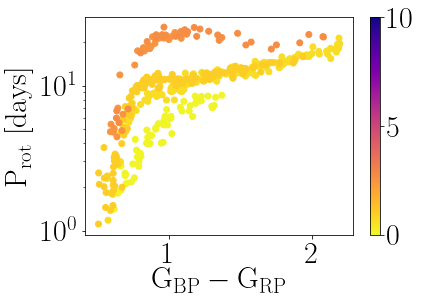

In [9]:
plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.colorbar();

100%|██████████| 35/35 [00:00<00:00, 2077.03it/s]


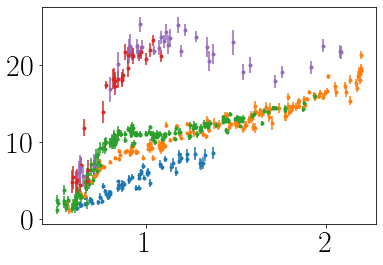

In [14]:
yerrors = []
for a in np.unique(cluster_age):
    age_mask = cluster_age == a
    
    x_, y_ = cluster_x[age_mask], cluster_prot[age_mask]
    stds = np.empty(len(y_))
    for i in trange(len(x_)):
        width = .1
        m = abs(x_[i] - x_) < width
        while sum(m) < 10:
            width += .1
            m = abs(x_[i] - x_) < width
        y_corrected, p = subtract_lil_line(x_[m], y_[m], 2)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
        
    plt.errorbar(cluster_x[age_mask], cluster_prot[age_mask], yerr=stds, fmt=".")
    yerrors.append(stds)
    
yerrors = np.array([i for j in yerrors for i in j])

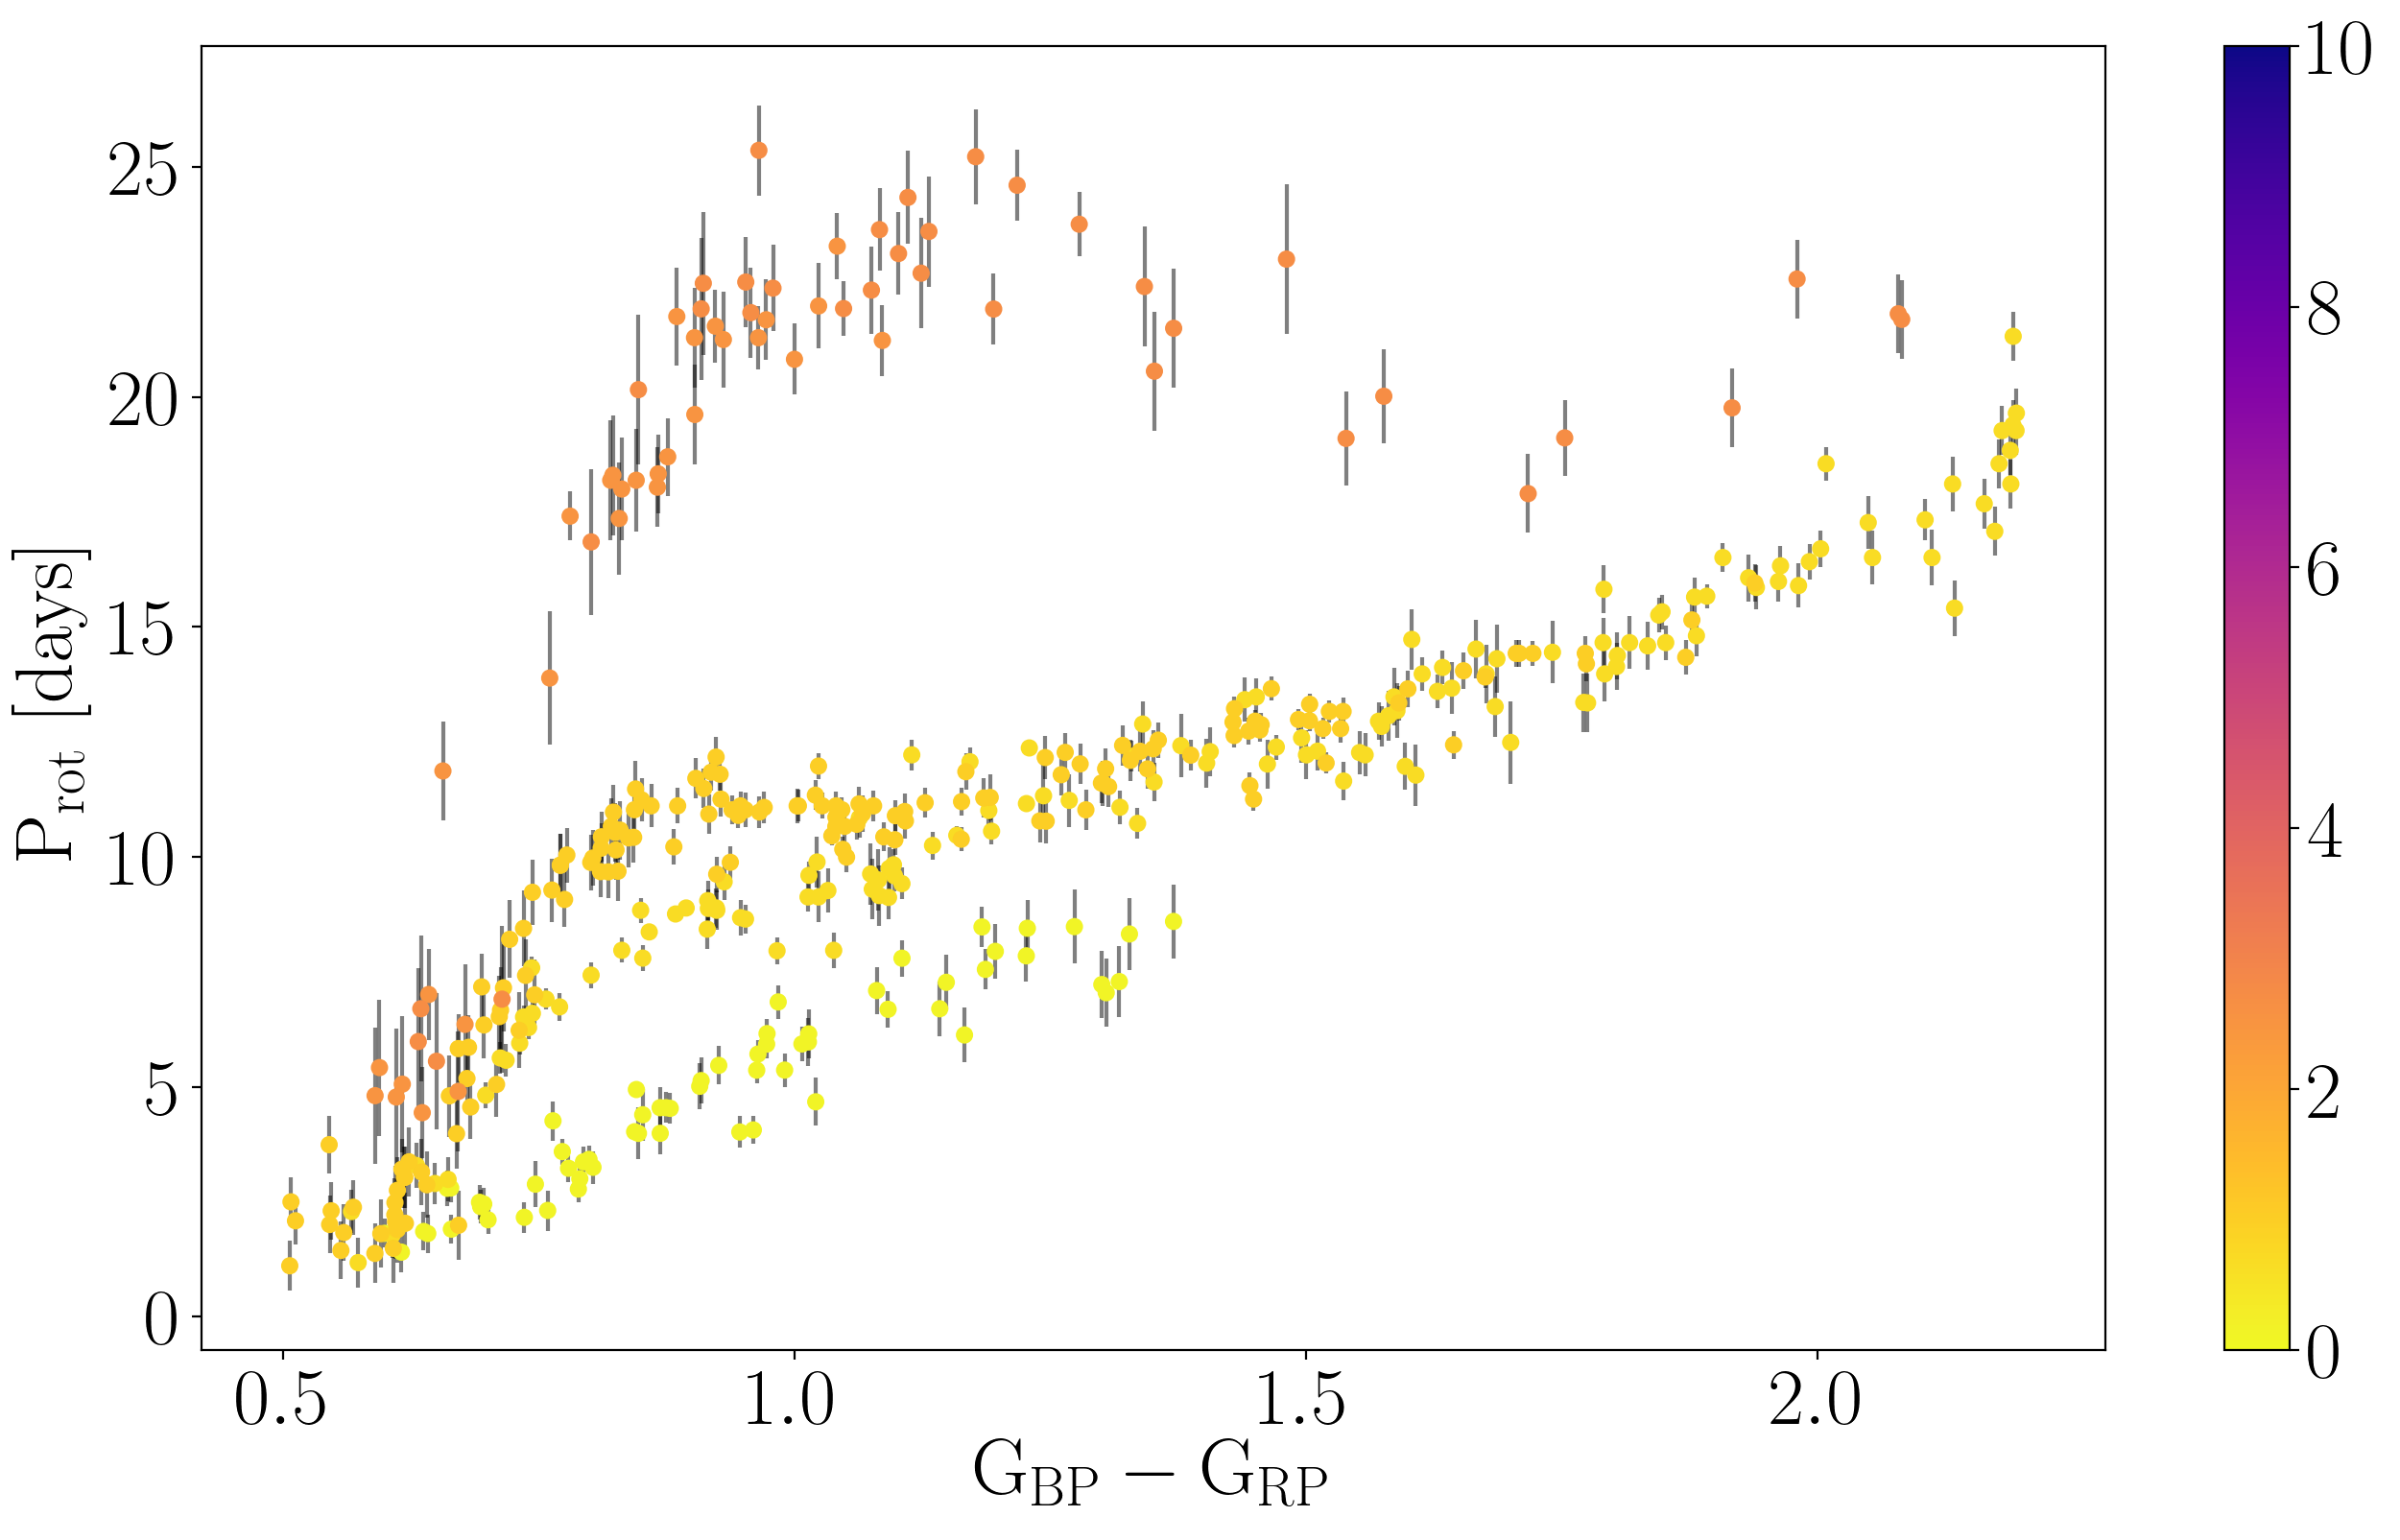

In [20]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(cluster_x, cluster_prot, yerr=yerrors, fmt="k.", alpha=.5, zorder=0)
plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=0, vmax=10, s=30, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.yscale("log")
plt.colorbar();

In [21]:
df = pd.DataFrame(dict({"bprp": cluster_x,
                        "prot": cluster_prot,
                        "age": cluster_age,
                        "prot_err": yerrors}))
df.to_csv("../data/clusters_with_uncertainties.csv")